<a href="https://colab.research.google.com/github/TacticalCoders/NLP-with-Pytorch/blob/main/5_3_Transfer_Learning_with_Pretrained_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전 훈련된 임베딩을 사용한 전이 학습

5.2절에서는 Embedding 층을 사용해 간단한 분류를 수행했다.

이 예제에서는 사전 훈련된 단어 임베딩을 로드하고, 뉴스 기사를 분류하여 사전 훈련된 임베딩을 미세 조정할 것이다. 그리고 마지막으로 단어 간의 공간 관계를 감지하는 합성곱 신경망을 사용할 것이다.

이처럼 한 작업에서 훈련된 모델을 다른 작업의 초기 모델로 사용하는 방식을 **전이 학습**(transfer learning)이라고 한다.

## AG 뉴스 데이터셋

AG 뉴스 데이터셋은 데이터 마이닝과 정보 추출 방법을 연구할 목적으로 2005년에 수집한 뉴스 기사 모음이다.(100만개 이상의 기사, 여기서는 12만개로 구성된 축소 버전 사용)

**기사 제목**에 초점을 맞춰 주어진 제목에서 **카테고리를 예측**하는 다중 분류 작업을 만들 것이다.

In [1]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 라이트 버전의 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/Jt1NH -O data/download.py
!wget https://git.io/Jt1NS -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

--2022-07-11 04:08:04--  https://git.io/Jt1NH
Resolving git.io (git.io)... 140.82.114.22
Connecting to git.io (git.io)|140.82.114.22|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_3_doc_classification/data/download.py [following]
--2022-07-11 04:08:04--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_3_doc_classification/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-07-11 04:08:04 (19.1 MB/s) - ‘data/download.py’ saved [1572/1572]

--2022-07-11 04:08:04--  htt

In [3]:
import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [4]:
args = Namespace(
    raw_dataset_csv="data/ag_news/news.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/ag_news/news_with_splits.csv",
    seed=1337
)

In [5]:
news = pd.read_csv(args.raw_dataset_csv, header=0)
news.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [6]:
set(news.category) # 카테고리 보기

{'Business', 'Sci/Tech', 'Sports', 'World'}

In [7]:
# 카테고리별로 분류하여 딕셔너리로 만들기
by_category = collections.defaultdict(list)
for _, row in news.iterrows():
    by_category[row.category].append(row.to_dict())

In [9]:
by_category.keys()

dict_keys(['Business', 'Sci/Tech', 'Sports', 'World'])

In [11]:
by_category.get('Sports')

[{'category': 'Sports',
  'title': 'Phelps, Thorpe Advance in 200 Freestyle (AP)'},
 {'category': 'Sports',
  'title': 'Reds Knock Padres Out of Wild-Card Lead (AP)'},
 {'category': 'Sports',
  'title': 'Dreaming done, NBA stars awaken to harsh Olympic reality (AFP)'},
 {'category': 'Sports',
  'title': 'Indians Beat Twins 7-1, Nearing AL Lead (AP)'},
 {'category': 'Sports', 'title': 'Galaxy, Crew Play to 0-0 Tie (AP)'},
 {'category': 'Sports',
  'title': 'USC Begins Season Where It Ended, at No. 1 (AP)'},
 {'category': 'Sports',
  'title': "Italy's Pennetta Wins Idea Prokom Open (AP)"},
 {'category': 'Sports', 'title': 'Tough Race Ahead for Swimmer Phelps'},
 {'category': 'Sports',
  'title': 'Iranian Will Not Meet Israeli in Olympics Due to Weight'},
 {'category': 'Sports',
  'title': 'Tiger Runs Out of Steam After Storming Start'},
 {'category': 'Sports', 'title': 'Colander Misses Chance to Emulate Jones'},
 {'category': 'Sports',
  'title': 'AL Wrap: Olerud Cheers Yankees by Sinkin

In [12]:
# 훈련, 검증, 테스트로 분할
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_category.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    final_list.extend(item_list)

In [13]:
final_news = pd.DataFrame(final_list) # 리스트를 데이터프레임으로

In [14]:
final_news.split.value_counts() # split 별 counts 조회

train    84000
val      18000
test     18000
Name: split, dtype: int64

In [15]:
# 전처리하기 (쉼표, 마침표, 느낌표, 물음표 주위에는 공백, 구두점 기호는 제거)
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
final_news.title = final_news.title.apply(preprocess_text)

In [16]:
final_news.head()

,category,title,split
0,Business,"jobs , tax cuts key issues for bush",train
1,Business,jarden buying mr . coffee s maker,train
2,Business,retail sales show festive fervour,train
3,Business,intervoice s customers come calling,train
4,Business,boeing expects air force contract,train


In [17]:
final_news.to_csv(args.output_munged_csv, index=False) # csv 파일로 저장

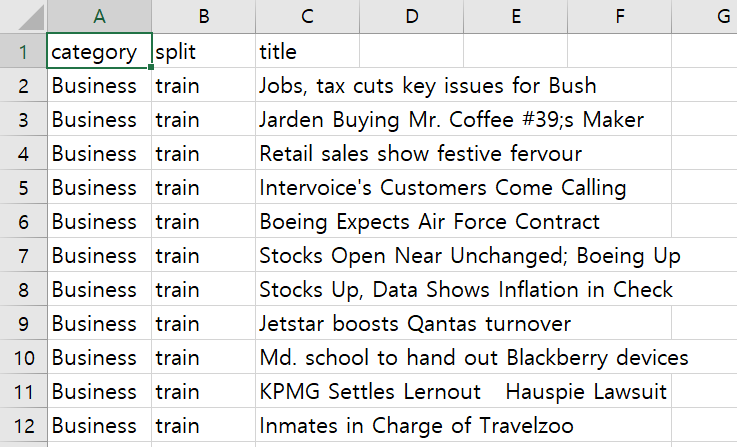

이렇게 생김

## Vocabulary

In [18]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [19]:
class Vocabulary(object):
    """매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """토큰 리스트를 Vocabulary에 추가합니다.
        
        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """토큰에 대응하는 인덱스를 추출합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.
        
        매개변수: 
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [20]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

Vocabulary 클래스를 상속한 SequenceVocabulary를 만든다. 이 클래스에는 시퀀스 데이터에 사용하는 특수 토큰 4개(UNK, MASK, BEGIN-OF-SEQUENCE, END-OF-SEQUENCE)가 있다.

UNK 토큰은 모델이 드물게 등장하는 단어에 대한 표현을 학습하도록 한다. (테스트 시에 본 적 없는 단어 처리)

MASK 토큰은 Embedding 층의 마스킹 역할을 수행하고 가변 길이의 시퀀스가 있을 때 손실 계산을 돕는다.

마지막으로 BOS 와 EOS는 시퀀스 경계에 관한 힌트를 신경망에 제공한다. (시작과 끝)

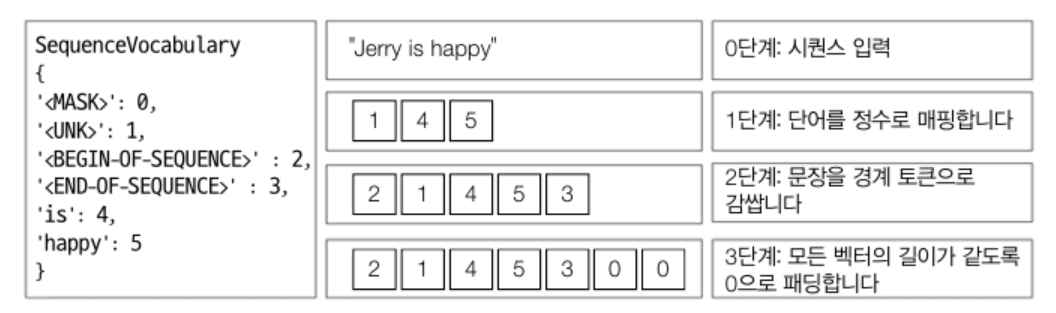

여기서 jerry는 UNK로 매핑되고 문장 경계를 표시하는 토큰을 추가한 뒤, 특정 길이까지 오른쪽에 0을 채워 데이터셋의 모든 벡터 길이를 통일한다.

## Vectorizer

여기서 Vectorizer는 단어 빈도를 계산하고 특정 임곗값을 지정하여 Vocabulary에서 사용할 수 있는 전체 단어 집합을 제한한다. 이렇게 하는 이유는 빈도가 낮은 잡은 단어를 제거하여 신호 품질을 개선하고 모델의 메모리 사용량 제약을 완화하기 위함이다.

In [21]:
class NewsVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title, vector_length=-1):
        """
        매개변수:
            title (str): 공백으로 나누어진 단어 문자열
            vector_length (int): 인덱스 벡터의 길이 매개변수
        반환값:
            벡터로 변환된 제목 (numpy.array)
        """
        indices = [self.title_vocab.begin_seq_index]
        indices.extend(self.title_vocab.lookup_token(token) 
                       for token in title.split(" "))
        indices.append(self.title_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, news_df, cutoff=25):
        """데이터셋 데이터프레임에서 Vectorizer 객체를 만듭니다
        
        매개변수:
            news_df (pandas.DataFrame): 타깃 데이터셋
            cutoff (int): Vocabulary에 포함할 빈도 임곗값
        반환값:
            NewsVectorizer 객체
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(news_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for title in news_df.title:
            for token in title.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = \
            SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab =  \
            Vocabulary.from_serializable(contents['category_vocab'])

        return cls(title_vocab=title_vocab, category_vocab=category_vocab)

    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

## Dataset

In [22]:
class NewsDataset(Dataset):
    def __init__(self, news_df, vectorizer):
        """
        매개변수:
            news_df (pandas.DataFrame): 데이터셋
            vectorizer (NewsVectorizer): 데이터셋에서 만든 NewsVectorizer 객체
        """
        self.news_df = news_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, news_df.title)) + 2
        

        self.train_df = self.news_df[self.news_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.news_df[self.news_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # 클래스 가중치
        class_counts = news_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        """데이터셋을 로드하고 처음부터 새로운 Vectorizer 만들기
        
        매개변수:
            news_csv (str): 데이터셋의 위치
        반환값:
            NewsDataset의 인스턴스
        """
        news_df = pd.read_csv(news_csv)
        train_news_df = news_df[news_df.split=='train']
        return cls(news_df, NewsVectorizer.from_dataframe(train_news_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        """ 데이터셋과 새로운 Vectorizer 객체를 로드합니다.
        캐시된 Vectorizer 객체를 재사용할 때 사용합니다.
        
        매개변수:
            news_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        반환값:
            NewsDataset의 인스턴스
        """
        news_df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 Vectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer_filepath (str): 직렬화된 Vectorizer 객체의 위치
        반환값:
            NewsVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """NewsVectorizer 객체를 json 형태로 디스크에 저장합니다
        
        매개변수:
            vectorizer_filepath (str): NewsVectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer

    def set_split(self, split="train"):
        """ 데이터프레임에 있는 열을 사용해 분할 세트를 선택합니다 """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드
        
        매개변수:
            index (int): 데이터 포인트의 인덱스
        반환값:
            데이터 포인트의 특성(x_data)과 레이블(y_target)로 이루어진 딕셔너리
        """
        row = self._target_df.iloc[index]

        title_vector = \
            self._vectorizer.vectorize(row.title, self._max_seq_length)

        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': title_vector,
                'y_target': category_index}

    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다
        
        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## 모델(NewsClassifier)

사전 훈련된 단어 임베딩을 초기 임베딩 행렬로 사용하려면 먼저 디스크에서 임베딩을 로드한 다음 실제 데이터에 있는 단어에 해당하는 임베딩의 임베딩의 일부를 선택한다. 그리고 Embedding 층의 가중치 행렬을 선택한 임베딩으로 지정한다.

만약 사전 훈련된 Glove 임베딩에 없는 단어가 등장하면 문제가 발생한다. 이를 처리하는데는 Xavier 균등 분포 같은 파이토치 라이브러리의 초기화 방법을 많이 사용한다.

In [29]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        매개변수:
            embedding_size (int): 임베딩 벡터의 크기
            num_embeddings (int): 임베딩 벡터의 개수
            num_channels (int): 합성곱 커널 개수
            hidden_dim (int): 은닉 차원 크기
            num_classes (int): 클래스 개수
            dropout_p (float): 드롭아웃 확률
            pretrained_embeddings (numpy.array): 사전에 훈련된 단어 임베딩
                기본값은 None 
            padding_idx (int): 패딩 인덱스
        """
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """분류기의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                x_in.shape는 (batch, dataset._max_seq_length)입니다.
            apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스-엔트로피 손실을 사용하려면 False로 지정합니다
        반환값:
            결과 텐서. tensor.shape은 (batch, num_classes)입니다.
        """
        
        # 임베딩을 적용하고 특성과 채널 차원을 바꿉니다
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # 평균 값을 계산하여 부가적인 차원을 제거합니다
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # MLP 분류기
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## 훈련

### 헬퍼 함수

In [23]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### 일반 유틸리티

In [24]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """GloVe 임베딩 로드 
    
    매개변수:
        glove_filepath (str): 임베딩 파일 경로 
    반환값:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    특정 단어 집합에 대한 임베딩 행렬을 만듭니다.
    
    매개변수:
        glove_filepath (str): 임베딩 파일 경로
        words (list): 단어 리스트
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

### 설정과 전처리 작업

In [25]:
from argparse import Namespace

args = Namespace(
    # 날짜와 경로 정보
    news_csv="data/ag_news/news_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch5/document_classification",
    # 모델 하이퍼파라미터
    glove_filepath='data/glove/glove.6B.100d.txt', 
    use_glove=False,
    embedding_size=100, 
    hidden_dim=100, 
    num_channels=100, 
    # 훈련 하이퍼파라미터
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.1, 
    batch_size=128, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # 실행 옵션
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	model_storage/ch5/document_classification/vectorizer.json
	model_storage/ch5/document_classification/model.pth
CUDA 사용여부: False


### 데이터 준비

In [26]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 라이트 버전의 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/Jt1NH -O data/download.py
!wget https://git.io/Jt1NS -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

mkdir: cannot create directory ‘data’: File exists
--2022-07-11 04:48:58--  https://git.io/Jt1NH
Resolving git.io (git.io)... 140.82.112.21
Connecting to git.io (git.io)|140.82.112.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_3_doc_classification/data/download.py [following]
--2022-07-11 04:48:58--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_3_doc_classification/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-07-11 04:48:58 (14.5 MB/s) - ‘data/download.

In [34]:
# GloVe 데이터를 다운로드합니다.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir -p data/glove
!mv glove.6B.100d.txt data/glove

--2022-07-11 04:57:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-11 04:57:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-11 04:57:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [35]:
args.use_glove = True

In [36]:
if args.reload_from_files:
    # 체크포인트를 로드합니다.
    dataset = NewsDataset.load_dataset_and_load_vectorizer(args.news_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# GloVe를 사용하거나 랜덤하게 임베딩을 초기화합니다
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("사전 훈련된 임베딩을 사용합니다")
else:
    print("사전 훈련된 임베딩을 사용하지 않습니다")
    embeddings = None

classifier = NewsClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.title_vocab),
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.category_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

사전 훈련된 임베딩을 사용합니다


### 훈련 반복

In [37]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(batch_dict['x_data'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------
            
            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier(batch_dict['x_data'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=train:   0%|          | 0/656 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


split=val:   0%|          | 0/140 [00:00<?, ?it/s]

## 평가

In [38]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_data'])
    
    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [39]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 0.6050473968897546;
테스트 정확도: 82.61718750000003


정확도가 매우 높다.

## 예측

In [40]:
# 리뷰 텍스트를 전처리합니다
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [46]:
def predict_category(title, classifier, vectorizer, max_length):
    """뉴스 제목을 기반으로 카테고리를 예측합니다
    
    매개변수:
        title (str): 원시 제목 문자열
        classifier (NewsClassifier): 훈련된 분류기 객체
        vectorizer (NewsVectorizer): 해당 Vectorizer
        max_length (int): 최대 시퀀스 길이
            노트: CNN은 입력 텐서 크기에 민감합니다. 
                 훈련 데이터처럼 동일한 크기를 갖도록 만듭니다.
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_category = vectorizer.category_vocab.lookup_index(indices.item())

    return {'category': predicted_category, 
            'probability': probability_values.item(), 'vectorized_title': vectorized_title}

In [47]:
def get_samples():
    samples = {}
    for cat in dataset.val_df.category.unique():
        samples[cat] = dataset.val_df.title[dataset.val_df.category==cat].tolist()[:5]
    return samples

val_samples = get_samples()

In [49]:
#title = input("Enter a news title to classify: ")
classifier = classifier.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Category: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_category(sample, classifier, 
                                      vectorizer, dataset._max_seq_length + 1)
        print("예측: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        print("\t + 샘플: {}".format(sample))
        print("vectorized_title : {}".format(prediction['vectorized_title']))
    print("-"*30 + "\n")

True Category: Business
예측: Business (p=0.96)
	 + 샘플: az suspends marketing of cancer drug
vectorized_title : tensor([   2,    1, 1974, 1299,   45,  505,  195,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
예측: Sci/Tech (p=0.52)
	 + 샘플: business world has mixed reaction to perez move
vectorized_title : tensor([  2, 112, 593, 967, 410,   1,  37,   1, 221,   3,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])
예측: Sports (p=0.55)
	 + 샘플: betting against bombay
vectorized_title : tensor([  2,   1, 444,   1,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])
예측: Business (p=0.99)
	 + 샘플: malpractice insurers face a tough market
vectorized_title : tensor([   2,    1,  137, 1046,  105, 1133,  218,    3,    0,    0,    0,    0

2는 문장의 시작을 알리는 토큰, 3은 문장의 끝을 알리는 토큰이다. 

입력된 문장을 고정된 크기로 맞추기 위해 나머지는 0으로 채운 것을 확인할 수 있다.